In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = './cleaned_dataset/data/00001.csv'
data = pd.read_csv(file_path)

# Calculate Remaining Useful Life (RUL)
data['RUL'] = data['Time'].max() - data['Time']

print(data['RUL'].head())

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for LSTM input
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-1]
        y = data[i+sequence_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 50
X, y = create_sequences(data_scaled, sequence_length)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the autoencoder model
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu')(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(n_features, activation='relu', return_sequences=True)(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, validation_split=0.2)


0    6436.141
1    6426.781
2    6412.860
3    6399.735
4    6386.516
Name: RUL, dtype: float64
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 0.2652 - val_loss: 0.1955
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1739 - val_loss: 0.1600
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1557 - val_loss: 0.1462
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1393 - val_loss: 0.1445
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1394 - val_loss: 0.1433
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1354 - val_loss: 0.1390
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1318 - val_loss: 0.1269
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1163 - val_loss: 0.1104
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1033 - val_loss: 0.1071
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1005 - val_loss: 0.1016
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0973 - val_l

In [4]:
# Define the encoder model
encoder = Model(inputs=input_layer, outputs=encoded)

# Encode the training and test data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


In [5]:
# Reshape X_train_encoded to have 3 dimensions
X_train_encoded = np.reshape(X_train_encoded, (X_train_encoded.shape[0], X_train_encoded.shape[1], 1))

# Define the LSTM model for RUL prediction
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(timesteps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
history = model.fit(X_train_encoded, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20


c:\Users\pavan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - loss: 0.2486 - val_loss: 0.1740
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1333 - val_loss: 0.0868
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0897 - val_loss: 0.0907
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0818 - val_loss: 0.0827
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0755 - val_loss: 0.0862
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0723 - val_loss: 0.0818
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0794 - val_loss: 0.0790
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0765 - val_loss: 0.0790
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0699 - val_loss: 0.0774
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0707 - val_loss: 0.0779
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0715 - val_loss: 0.0779
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0727 - val_loss: 0.0758
Epoch 13/2

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Mean Absolute Error (MAE): 1553.2254194605887
Root Mean Squared Error (RMSE): 1757.8159518614048


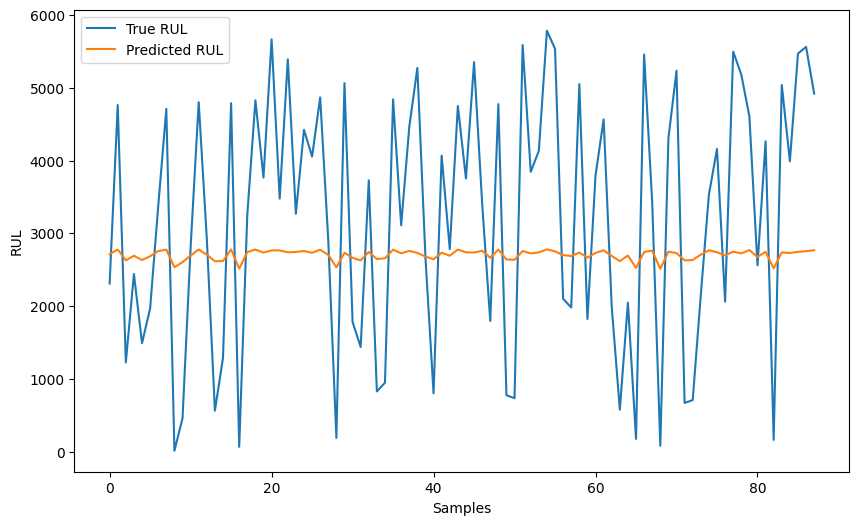

In [6]:
# Predict RUL on test data
y_pred = model.predict(X_test_encoded)

# Rescale the predicted and true values back to original scale
y_test_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], data.shape[1] - 1)), y_test.reshape(-1, 1))))[:, -1]
y_pred_rescaled = scaler.inverse_transform(np.hstack((np.zeros((y_pred.shape[0], data.shape[1] - 1)), y_pred)))[:, -1]

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plot true vs predicted RUL
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True RUL')
plt.plot(y_pred_rescaled, label='Predicted RUL')
plt.xlabel('Samples')
plt.ylabel('RUL')
plt.legend()
plt.show()
